In [1]:
from edc import check_compatibility
check_compatibility("user-2023.03-02", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


# Using eo-learn in EDC: a starter's guide.
---
Source: [eo-learn Python package documentation](https://eo-learn.readthedocs.io/en/latest/)

## Getting started with `eo-learn`

**eo-learn** is a collection of open source Python packages that have been developed to seamlessly access and process spatio-temporal image sequences acquired by any satellite fleet in a timely and automatic manner. eo-learn is easy to use, it’s design modular, and encourages collaboration – sharing and reusing of specific tasks in a typical EO-value-extraction workflows, such as cloud masking, image co-registration, feature extraction, classification, etc.

eo-learn makes extraction of valuable information from satellite imagery as easy as defining a sequence of operations to be performed on satellite imagery. Image below illustrates a processing chain that maps water in satellite imagery by thresholding the Normalised Difference Water Index in user specified region of interest.

![eo-learn workflow](https://eo-learn.readthedocs.io/en/latest/_images/eo-learn-illustration.png)

**eo-learn** acts as a bridge between Earth observation/Remote sensing field and Python ecosystem for data science and machine learning. The library is written in Python and uses NumPy arrays to store and handle remote sensing data. Its aim is to make entry easier for non-experts to the field of remote sensing on one hand and bring the state-of-the-art tools for computer vision, machine learning, and deep learning existing in Python ecosystem to remote sensing experts.

**eo-learn** is divided into several subpackages according to different functionalities and external package dependencies. Therefore it is not necessary for user to install entire package but only the parts that he needs.

At the moment there are the following subpackages:

- *eo-learn-core* - The main subpackage which implements basic building blocks (EOPatch, EOTask and EOWorkflow) and commonly used functionalities.

- *eo-learn-coregistration* - The subpackage that deals with image co-registraion.

- *eo-learn-features* - A collection of utilities for extracting data properties and feature manipulation.

- *eo-learn-geometry* - Geometry subpackage used for geometric transformation and conversion between vector and raster data.

- *eo-learn-io* - Input/output subpackage that deals with obtaining data from Sentinel Hub services or saving and loading data locally.

- *eo-learn-mask* - The subpackage used for masking of data and calculation of cloud masks.

- *eo-learn-ml-tools* - Various tools that can be used before or after the machine learning process.

- *eo-learn-visualization* - Visualization tools for core elements of eo-learn.

## Outline

In this demonstration Jupyter Notebook, based on the [Spatio-Temporal Feature notebook](https://github.com/sentinel-hub/eo-learn/blob/master/examples/features/SpatioTemporalFeatures.ipynb), we will learn how to:

- [Create an `EOWorkflow`](#Create-an-EOWorkflow)
- [Visualize the `EOPatch` output from the `EOWorkflow`](#Visualize-the-EOPatch-output-from-the-EOWorkflow)
  - [`VALID_DATA` mask](#VALID_DATA-mask)
  - [Cloud cover](#Cloud-cover)
  - [Spatiotemporal features of a specific field](#Spatiotemporal-features-of-a-specific-field)
  - [Distribution of temporal indices](#Distribution-of-temporal-indices)
  - [False color images of NDVI features](#False-color-images-of-NDVI-features)
- [Load an existing `EOPatch` from a filesystem to build another `EOWorkflow`](#Load-an-existing-EOPatch-from-a-filesystem-to-build-another-EOWorkflow)

## Prerequisites

Before starting to build our own processing chain for Earth Observation (EO) data, we need to import necessary Python libraries (already configured in your EDC workplace) and generate credentials automatically to access the services.

In [2]:
# EDC libraries
from edc import setup_environment_variables

# Utilities
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# eo-learn
from eolearn.core import (LoadTask, SaveTask, EONode, EOWorkflow, FeatureType, EOPatch, 
                          linearly_connect_tasks, ZipFeatureTask, OutputTask)
from eolearn.io import SentinelHubInputTask
from eolearn.features import (AddSpatioTemporalFeaturesTask, AddMaxMinTemporalIndicesTask, 
                              AddMaxMinNDVISlopeIndicesTask, NormalizedDifferenceIndexTask)
from eolearn.features.interpolation import LinearInterpolationTask

# Sentinel Hub
from sentinelhub import BBox, CRS, DataCollection, SHConfig

In [3]:
# Supress warnings for a neater notebook
warnings.filterwarnings("ignore")

In [4]:
# Add plot to the Jupyter Notebook
%matplotlib inline

#### Credentials

Credentials for Sentinel Hub services are automatically injected as environement variables. It is therefore easy to populate Sentinel Hub's credential manager with the values.

In [5]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

## Create an `EOWorkflow`

In the following cell, we will create an `EOWorkflow` implementing the spatiotemporal features proposed by *Waldner et al., 2015* [1].  

The workflow consists of: 
- a task to download Sentinel-2 data
- a task to calculate NDVI
- a task to generate valid data mask
- a task to compute the argmax and argmin of NDVI
- a task to compute the argmax and argmin of the red band
- a task to compute the argmax and argmin of NDVI slope
- a task to compute spatiotemporal features correspond to the concatenation of reflectance (green, red, NIR and SWIR) values taken at dates where:
  - NDVI is maximum
  - NDVI is minimum
  - red reflectance are maximum
  - NDVI slope is maximum
  - NDVI slope is minimum
- a task to save the given `EOPatch` to a filesystem
- a task to keep the eo-patch in memory after the completion of the workflow

After each task is defined as an `EOTask`, we can wrap `EOTasks` into `EONodes` and assemble all `EONodes` to form an `EOWorkflow` ready to be executed.

[1] Waldner et al. "Automated Annual Cropland Mapping Using Knowledge-based Temporal Features", 2015 ISPRS Journal of Photogrammetrz and Remote Sensing.

In [6]:
# Define `EOTasks`
add_data_task = SentinelHubInputTask(
    data_collection = DataCollection.SENTINEL2_L1C, 
    bands_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    time_difference = timedelta(hours=2),
    resolution=20,
    additional_data = [
        (FeatureType.MASK, 'CLM'),
        (FeatureType.MASK, 'dataMask', 'IS_DATA'), # assigning 'dataMask' band to 'IS_DATA'
    ],
    config=config
)

ndvi_task = NormalizedDifferenceIndexTask(
    input_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    output_feature=(FeatureType.DATA, 'NDVI'),
    bands = [7,2]    
)

# Define a task using ZipFeatureTask
class AddValidDataMaskTask(ZipFeatureTask):
    def zip_method(self, *mask):
        return np.logical_and(
            mask[0].astype(bool), # 0 to False and 1 to True
            np.logical_not((mask[1] != 0).astype(bool)) # CLM==1 or CLM==255 (clouds and no data) to False CLM==0 (clear) to True
        )
add_valmask = AddValidDataMaskTask({FeatureType.MASK: ['IS_DATA', 'CLM']}, (FeatureType.MASK, 'VALID_DATA'))

add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=True)

add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature='BANDS-S2-L1C', 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=True)

add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()

add_stf = AddSpatioTemporalFeaturesTask()

save_task = SaveTask('./stf', overwrite_permission=1, compress_level=0)

output_task = OutputTask("eopatch")

**Quick tip:**

`SentinelHubInputTask()`, `NormalizedDifferenceIndexTask()`, `AddMaxMinTemporalIndicesTask()`, `AddMaxMinTemporalIndicesTask()`, `AddMaxMinNDVISlopeIndicesTask()`, `AddSpatioTemporalFeaturesTask()`, `SaveTask()`, `OutputTask` are pre-defined functions performing the tasks listed above. You can also defined your own `EOTask` as shown below:
```python
class FooTask(EOTask):
    def __init__(self, foo_param):
        self.foo_param = foo_param
        
    def execute(self, eopatch, *, patch_specific_param):
        # do what foo does on input eopatch and return it
        return eopatch
```
For more detail and other pre-defined functions please refer to our `eo-learn` [documentation](https://eo-learn.readthedocs.io/en/latest/eolearn.html).

Next, we can wrap `EOTasks` into `EONode`, join all the `EONodes` together into an acyclic executable `EOWorkflow`, and visualize it with `dependency_graph()` function. Below demonstrates the most comprehensive way to build a `EOWorkflow`. Other simplified methods can be found in the [documentation](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EONode-and-EOWorkflow).

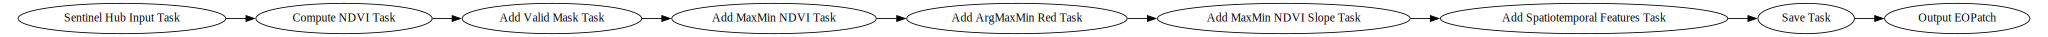

In [7]:
# Wrap `EOTasks` into `EONode`
add_data_node = EONode(add_data_task, inputs=[], name="Sentinel Hub Input Task")
ndvi_node = EONode(ndvi_task, inputs=[add_data_node], name="Compute NDVI Task")
add_valmask_node = EONode(add_valmask, inputs=[ndvi_node], name="Add Valid Mask Task")
add_maxmin_ndvi_node = EONode(add_maxmin_ndvi, inputs=[add_valmask_node], name="Add MaxMin NDVI Task")
add_maxmin_red_node = EONode(add_maxmin_red, inputs=[add_maxmin_ndvi_node], name="Add ArgMaxMin Red Task")
add_maxmin_ndvi_sl_node = EONode(add_maxmin_ndvi_sl, inputs=[add_maxmin_red_node], name="Add MaxMin NDVI Slope Task")
add_stf_node = EONode(add_stf, inputs=[add_maxmin_ndvi_sl_node], name="Add Spatiotemporal Features Task")
save_task_node = EONode(save_task, inputs=[add_stf_node], name="Save Task")
output_node = EONode(output_task, inputs=[save_task_node], name="Output EOPatch")

# Assemble `EOTasks` to an `EOWorkflow`
workflow = EOWorkflow(
    [
        add_data_node,
        ndvi_node,
        add_valmask_node,
        add_maxmin_ndvi_node,
        add_maxmin_red_node,
        add_maxmin_ndvi_sl_node,
        add_stf_node,
        save_task_node,
        output_node
    ]
)


# Visualize the `EOWorkflow`
workflow.dependency_graph()

Now we need to define an area of interest and a time interval for the implementation of our `EOWorkflow`.

In [8]:
# Define the area of interest and time interval
aoi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-04-01', '2017-10-31')

Finally, we execute the workflow in the following cell.

In [9]:
result = workflow.execute({
    add_data_node: {'bbox': aoi_bbox, 'time_interval': time_interval},
    save_task_node: {'eopatch_folder': 'eopatch'}
})

## Visualize the `EOPatch` output from the `EOWorkflow`

Once the `EOWorkflow` is run and done processing, we can open the result as an `EOPatch`. The following cell shows the way to open the results of an `EOWorkflow` as an `EOPatch` and the structure of EO data stored inside it.

In [10]:
# Open data output from `EOWorkflow`
# The key of outputs is defined by OutputTask()
eop = result.outputs["eopatch"]
eop

EOPatch(
  data={
    BANDS-S2-L1C: numpy.ndarray(shape=(66, 297, 497, 13), dtype=float32)
    NDVI: numpy.ndarray(shape=(66, 297, 497, 1), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=bool)
  }
  data_timeless={
    ARGMAX_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    STF: numpy.ndarray(shape=(297, 497, 20), dtype=float32)
  }
  bbox=BBox(((5.6, 52.63), (5.75, 52.68)), crs=CRS('4326'))
  timestamps=[datetime.datetime(2017, 4, 3, 10, 41, 38), ..., datetime.datetime(2017, 10, 30, 10

### `VALID_DATA` mask

Below we visualize how a valid data mask is generated. [`ZipFeatureTask`](https://eo-learn.readthedocs.io/en/latest/eolearn.core.core_tasks.html#eolearn.core.core_tasks.ZipFeatureTask) allows us to feed in a self-defined formula that takes multiple inputs and returns a single output. In this Jupyter Notebook we define `AddValidDataMaskTask()` on the top of `ZipFeatureTask` to combine `IS_DATA` (taken from [dataMask](https://docs.sentinel-hub.com/api/latest/user-guides/datamask/)) and `CLM` (see [description](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/)) to form the `VALID_DATA` mask. Pixel values are valid only if `IS_DATA` is `True` (there is data) and `CLM` is `False` (no clouds).

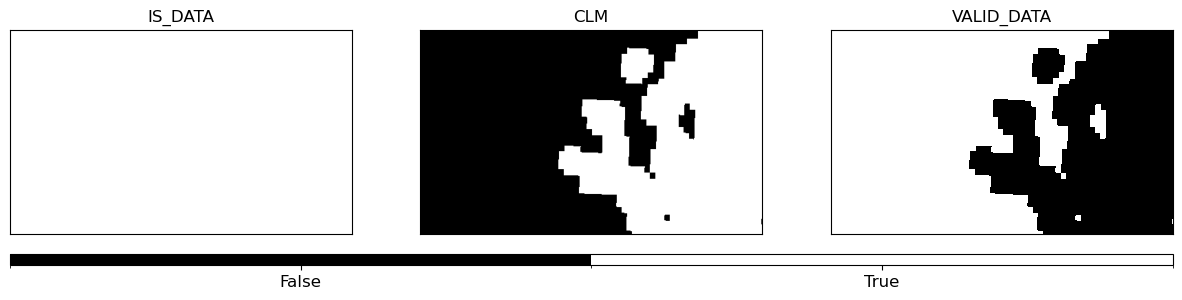

In [11]:
ts_idx = 5

subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw=subplot_kw)

ax = axs[0]
ax.imshow(eop.mask['IS_DATA'][ts_idx].squeeze(), vmin=0, vmax=1, cmap='gray')
ax.set_title('IS_DATA')

ax = axs[1]
ax.imshow(eop.mask['CLM'][ts_idx].squeeze(),  vmin=0, vmax=1, cmap='gray')
ax.set_title('CLM')

ax = axs[2]
im = ax.imshow(eop.mask['VALID_DATA'][ts_idx].squeeze(),
               cmap=ListedColormap(['#000000', '#ffffff']), 
               norm=BoundaryNorm([-0.5, 0.5, 1.5], 2))
ax.set_title('VALID_DATA')

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.05, aspect=100)
cb.set_ticks([0,1])
cb.ax.set_xticklabels([False, True], fontsize=12);

### Cloud cover

We can also calculate the cloud cover percentage and visualize its changes along the timestamps of data.

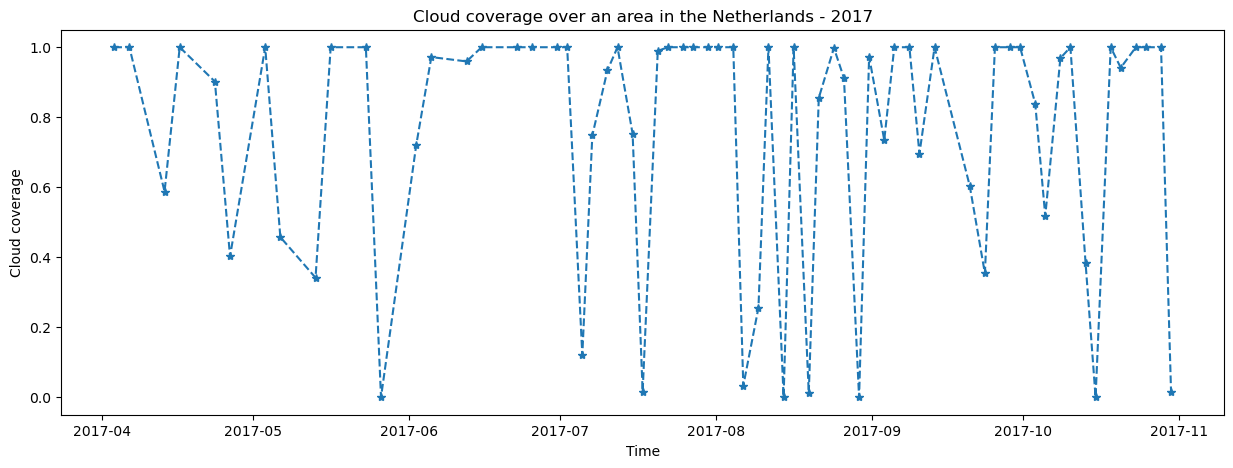

In [12]:
# cloud coverage
cc = [np.sum(x)/(np.prod(x.shape)) for x in eop.mask['CLM']]

fix, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(eop.timestamp, cc, '*--')
plt.ylabel('Cloud coverage')
plt.xlabel('Time')
plt.title('Cloud coverage over an area in the Netherlands - 2017');

### Spatiotemporal features of a specific field

If we're looking into a specific field, it is easy to slice the field out of the `EOPatch` and visualize its NDVI variation thourghout the timestamps.

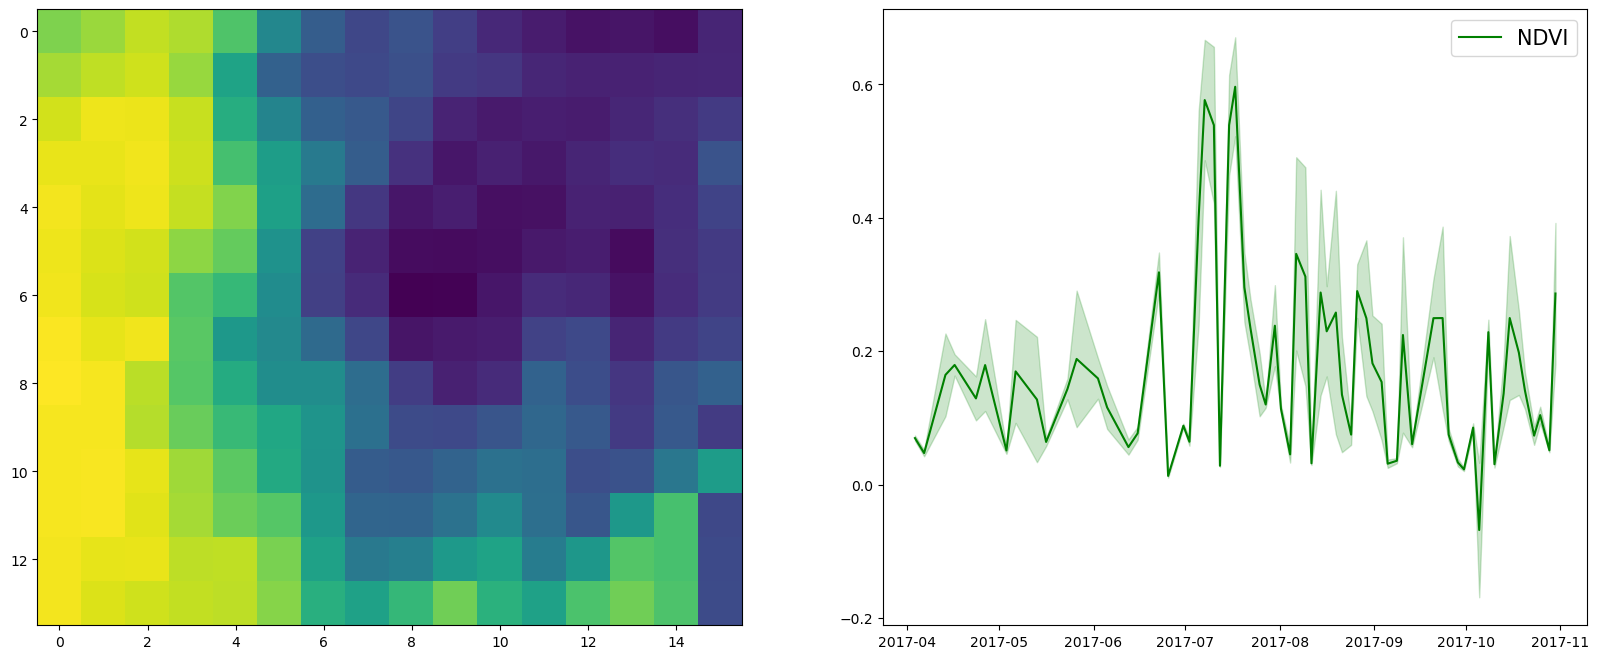

In [13]:
field_mask = (slice(None), slice(227, 241), slice(314,330))
ndvi_patch = eop.data['NDVI'][field_mask].squeeze(-1)

fix, axs = plt.subplots(1,2,figsize=(20,8))

ax = axs[0]
ax.imshow(ndvi_patch[20])
ax.set_aspect('auto')

ax = axs[1]
mean = np.mean(ndvi_patch, axis=(1,2))
std = np.std(ndvi_patch, axis=(1,2))
ax.plot(eop.timestamp, mean, color='g', label='NDVI')
ax.fill_between(eop.timestamp, mean-std, mean+std, alpha=0.2, color='g');
ax.set_aspect('auto')

plt.legend(fontsize=15);

### Distribution of temporal indices

In the following cell we visualize the distribution of temporal indices having the maximum or minimum values of NDVI features, which gives an overview on when most of the fields have maximum or minimum values of NDVI features.

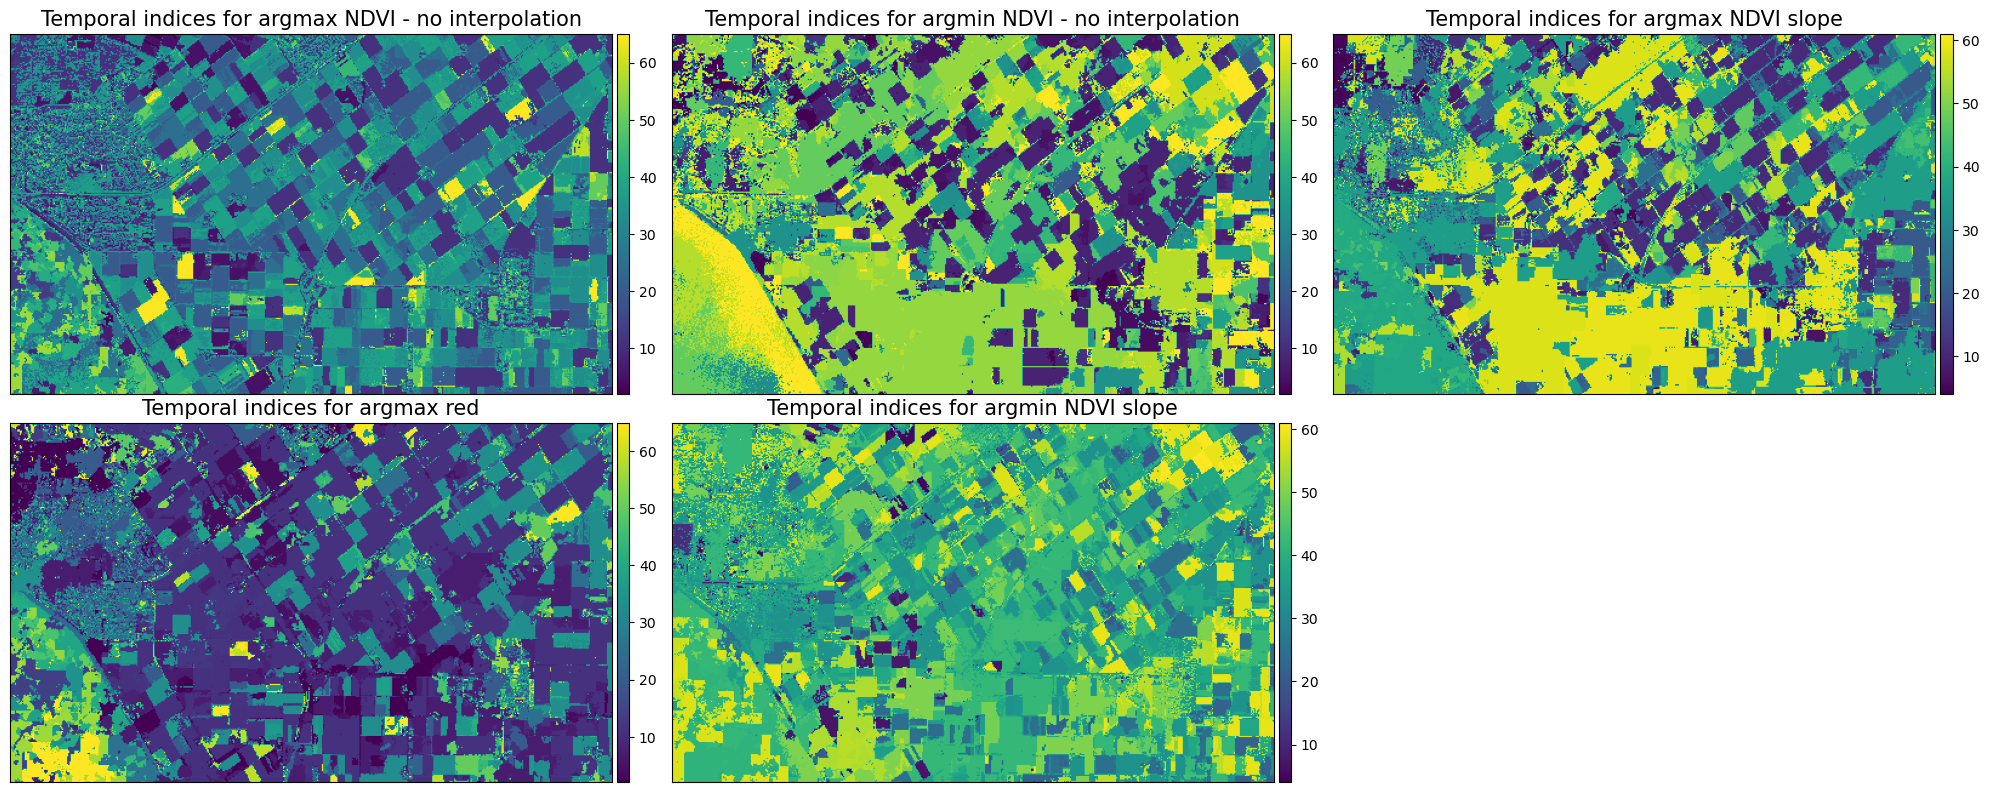

In [14]:
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,8), subplot_kw = subplot_kw)

ax = axs[0,0]
im = ax.imshow(eop.data_timeless['ARGMAX_NDVI'].squeeze())
ax.set_title("Temporal indices for argmax NDVI - no interpolation", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,1]
im = ax.imshow(eop.data_timeless['ARGMIN_NDVI'].squeeze())
ax.set_title("Temporal indices for argmin NDVI - no interpolation", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,2]
im = ax.imshow(eop.data_timeless['ARGMAX_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmax NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,1]
im = ax.imshow(eop.data_timeless['ARGMIN_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmin NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,0]
im = ax.imshow(eop.data_timeless['ARGMAX_B4'].squeeze())
ax.set_title("Temporal indices for argmax red", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()

### False color images of NDVI features

Traditionally a combination of infrared-red-green false color image is useful for vegetation monitoring. Below we visualize the false color images of NDVI features to have an overview on vegetation changes during a crop cycle. 

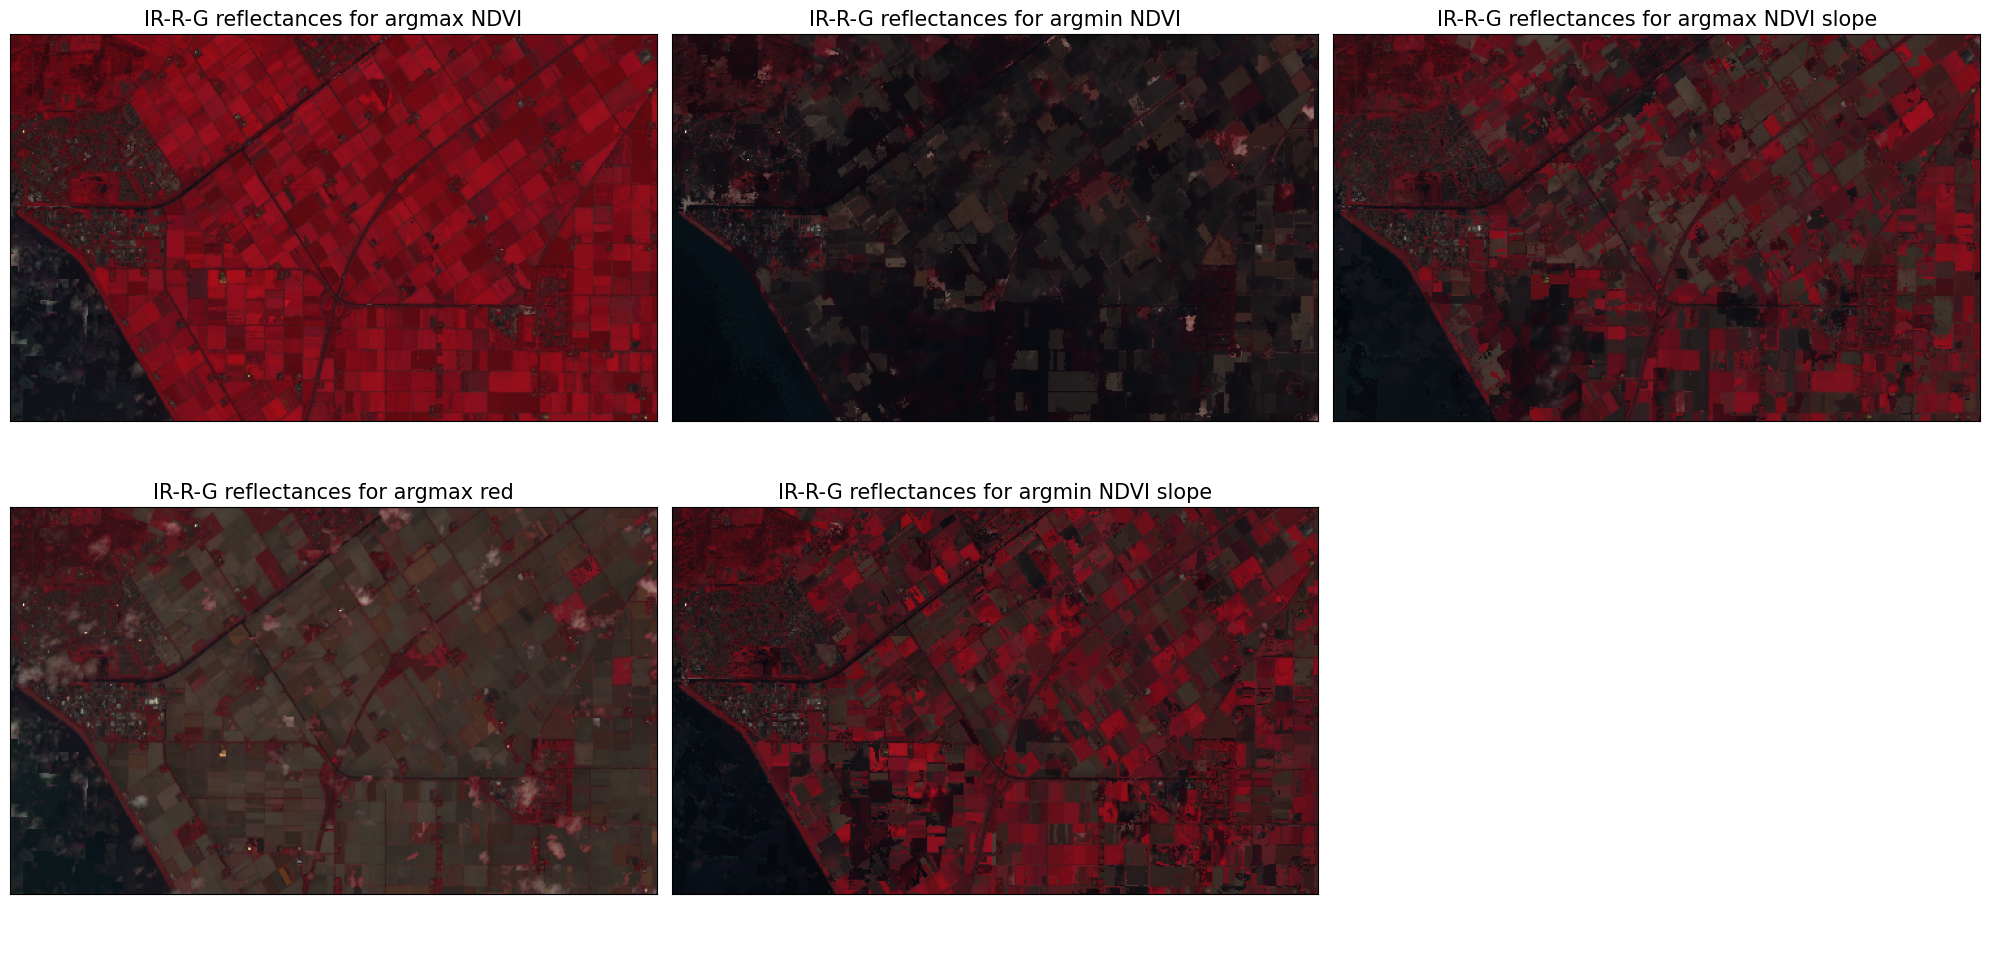

In [15]:
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,10), subplot_kw = subplot_kw)

ax = axs[0,0]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[2,1,0]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI", fontsize=15)

ax = axs[0,1]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[6,5,4]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI", fontsize=15)

ax = axs[0,2]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[10,9,8]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI slope", fontsize=15)

ax = axs[1,1]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[14,13,12]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI slope", fontsize=15)

ax = axs[1,0]
ax.imshow(np.clip(eop.data_timeless['STF'][:,:,[18,17,16]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax red", fontsize=15);

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()

## Load an existing `EOPatch` from a filesystem to build another `EOWorkflow`

In the previous processing chain, we calculated spatiotemporal indices via masking out invalid data which could lead to data gaps within the time interval. From a machine learning perspective, we train models to recognize features of indices' temporal changes, meaning that data gaps should be avoided. One way to solve this problem is to create a homogenous temporal data-stack using interpolation. Since the changes of vegetation is usually a slow process over time, it is reasonable to implement a linear interpolation to fill up the missing data to make our data better for ML training. Here we will show how to build another `EOWorkflow` to implement interpolation before calculating spatiotemporal indices in a few steps:
- Load the previously saved `EOPatch`
- Define `EOTasks` implementing interpolation
- Wrap `EOTasks` into `EONodes`
- Build a new `EOWorkflow` from `EONodes`

In [16]:
# Load existing `EOPatch`
load_task = LoadTask('./stf/')

# Define new `EOTasks`
interp_ndvi = LinearInterpolationTask((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'))

interp_bands = LinearInterpolationTask((FeatureType.DATA, 'BANDS-S2-L1C'), mask_feature=(FeatureType.MASK, 'VALID_DATA'))

add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=False)

add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature='BANDS-S2-L1C', 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=False)

add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()

add_stf = AddSpatioTemporalFeaturesTask()

output = OutputTask("interp_eopatch")

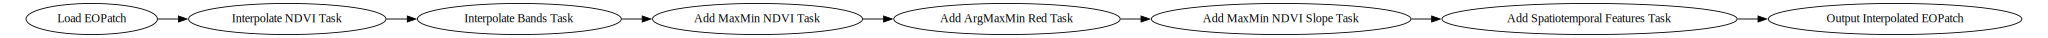

In [17]:
# Wrap `EOTasks` into `EONodes`
load_node = EONode(load_task, inputs=[], name="Load EOPatch")
interp_ndvi_node = EONode(interp_ndvi, inputs=[load_node], name="Interpolate NDVI Task")
interp_bands_node = EONode(interp_bands, inputs=[interp_ndvi_node], name="Interpolate Bands Task")
add_maxmin_ndvi_node = EONode(add_maxmin_ndvi, inputs=[interp_bands_node], name="Add MaxMin NDVI Task")
add_maxmin_red_node = EONode(add_maxmin_red, inputs=[add_maxmin_ndvi_node], name="Add ArgMaxMin Red Task")
add_maxmin_ndvi_sl_node = EONode(add_maxmin_ndvi_sl, inputs=[add_maxmin_red_node], name="Add MaxMin NDVI Slope Task")
add_stf_node = EONode(add_stf, inputs=[add_maxmin_ndvi_sl_node], name="Add Spatiotemporal Features Task")
output_node = EONode(output, inputs=[add_stf_node], name="Output Interpolated EOPatch")

# Assemble `EONodes` to an `EOWorkflow`
workflow_with_interp = EOWorkflow(
    [
        load_node,
        interp_ndvi_node,
        interp_bands_node,
        add_maxmin_ndvi_node,
        add_maxmin_red_node,
        add_maxmin_ndvi_sl_node,
        add_stf_node,
        output_node
    ]
)

# Visualize new `EOWorkflow`
workflow_with_interp.dependency_graph()

In [18]:
# Execute new `EOWorkflow`
result_with_interp = workflow_with_interp.execute({
    load_node: {'eopatch_folder':'eopatch'}
})

## Visualize interpolated data

Again we can vasualize the interpolated data in the same way as demonstrated above and see how data gaps over time could affect on the features of indices' temporal variation. 

In [19]:
# Open data output from `EOWorkflow`
eop_interp = result_with_interp.outputs["interp_eopatch"]
eop_interp

EOPatch(
  data={
    BANDS-S2-L1C: numpy.ndarray(shape=(66, 297, 497, 13), dtype=float64)
    NDVI: numpy.ndarray(shape=(66, 297, 497, 1), dtype=float64)
  }
  mask={
    CLM: numpy.ndarray(shape=(66, 297, 497, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(66, 297, 497, 1), dtype=bool)
  }
  data_timeless={
    ARGMAX_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(297, 497, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(297, 497, 1), dtype=uint8)
    STF: numpy.ndarray(shape=(297, 497, 20), dtype=float64)
  }
  bbox=BBox(((5.6, 52.63), (5.75, 52.68)), crs=CRS('4326'))
  timestamps=[datetime.datetime(2017, 4, 3, 10, 41, 38), ..., datetime.datetime(2017, 10, 30, 10

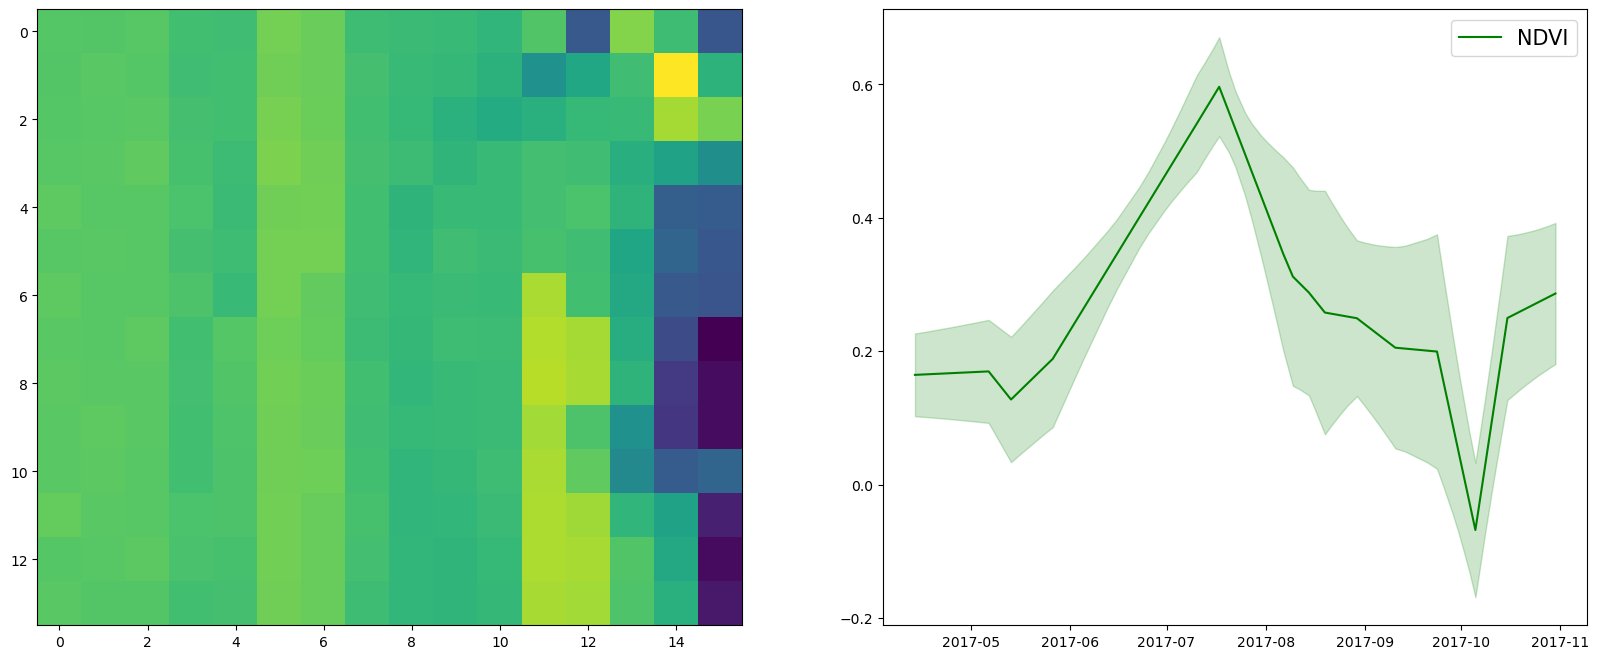

In [20]:
# Visualize spatiotemporal features of a specific field
field_mask = (slice(None), slice(227, 241), slice(314,330))
ndvi_patch = eop_interp.data['NDVI'][field_mask].squeeze(-1)

fix, axs = plt.subplots(1,2,figsize=(20,8))

ax = axs[0]
ax.imshow(ndvi_patch[20])
ax.set_aspect('auto')

ax = axs[1]
mean = np.mean(ndvi_patch, axis=(1,2))
std = np.std(ndvi_patch, axis=(1,2))
ax.plot(eop_interp.timestamp, mean, color='g', label='NDVI')
ax.fill_between(eop_interp.timestamp, mean-std, mean+std, alpha=0.2, color='g');
ax.set_aspect('auto')

plt.legend(fontsize=15);

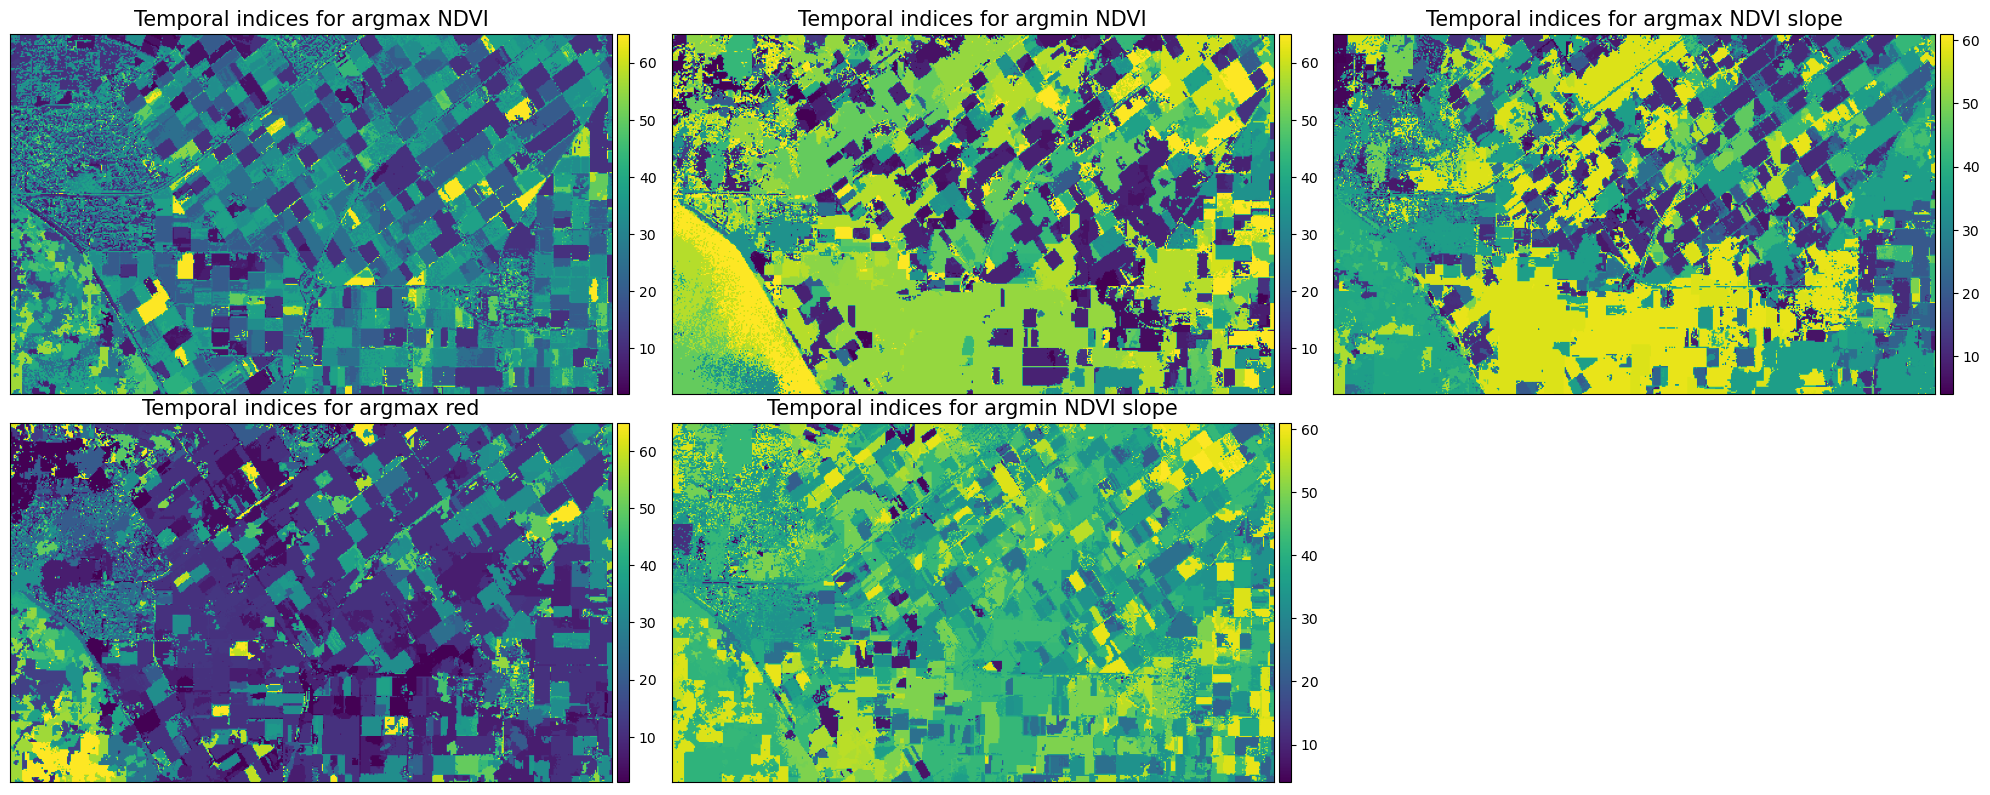

In [21]:
# Distribution of temporal indices
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,8), subplot_kw = subplot_kw)

ax = axs[0,0]
im = ax.imshow(eop_interp.data_timeless['ARGMAX_NDVI'].squeeze())
ax.set_title("Temporal indices for argmax NDVI", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,1]
im = ax.imshow(eop_interp.data_timeless['ARGMIN_NDVI'].squeeze())
ax.set_title("Temporal indices for argmin NDVI", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[0,2]
im = ax.imshow(eop_interp.data_timeless['ARGMAX_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmax NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,1]
im = ax.imshow(eop_interp.data_timeless['ARGMIN_NDVI_SLOPE'].squeeze())
ax.set_title("Temporal indices for argmin NDVI slope", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,0]
im = ax.imshow(eop_interp.data_timeless['ARGMAX_B4'].squeeze())
ax.set_title("Temporal indices for argmax red", fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im, cax=cax)

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()

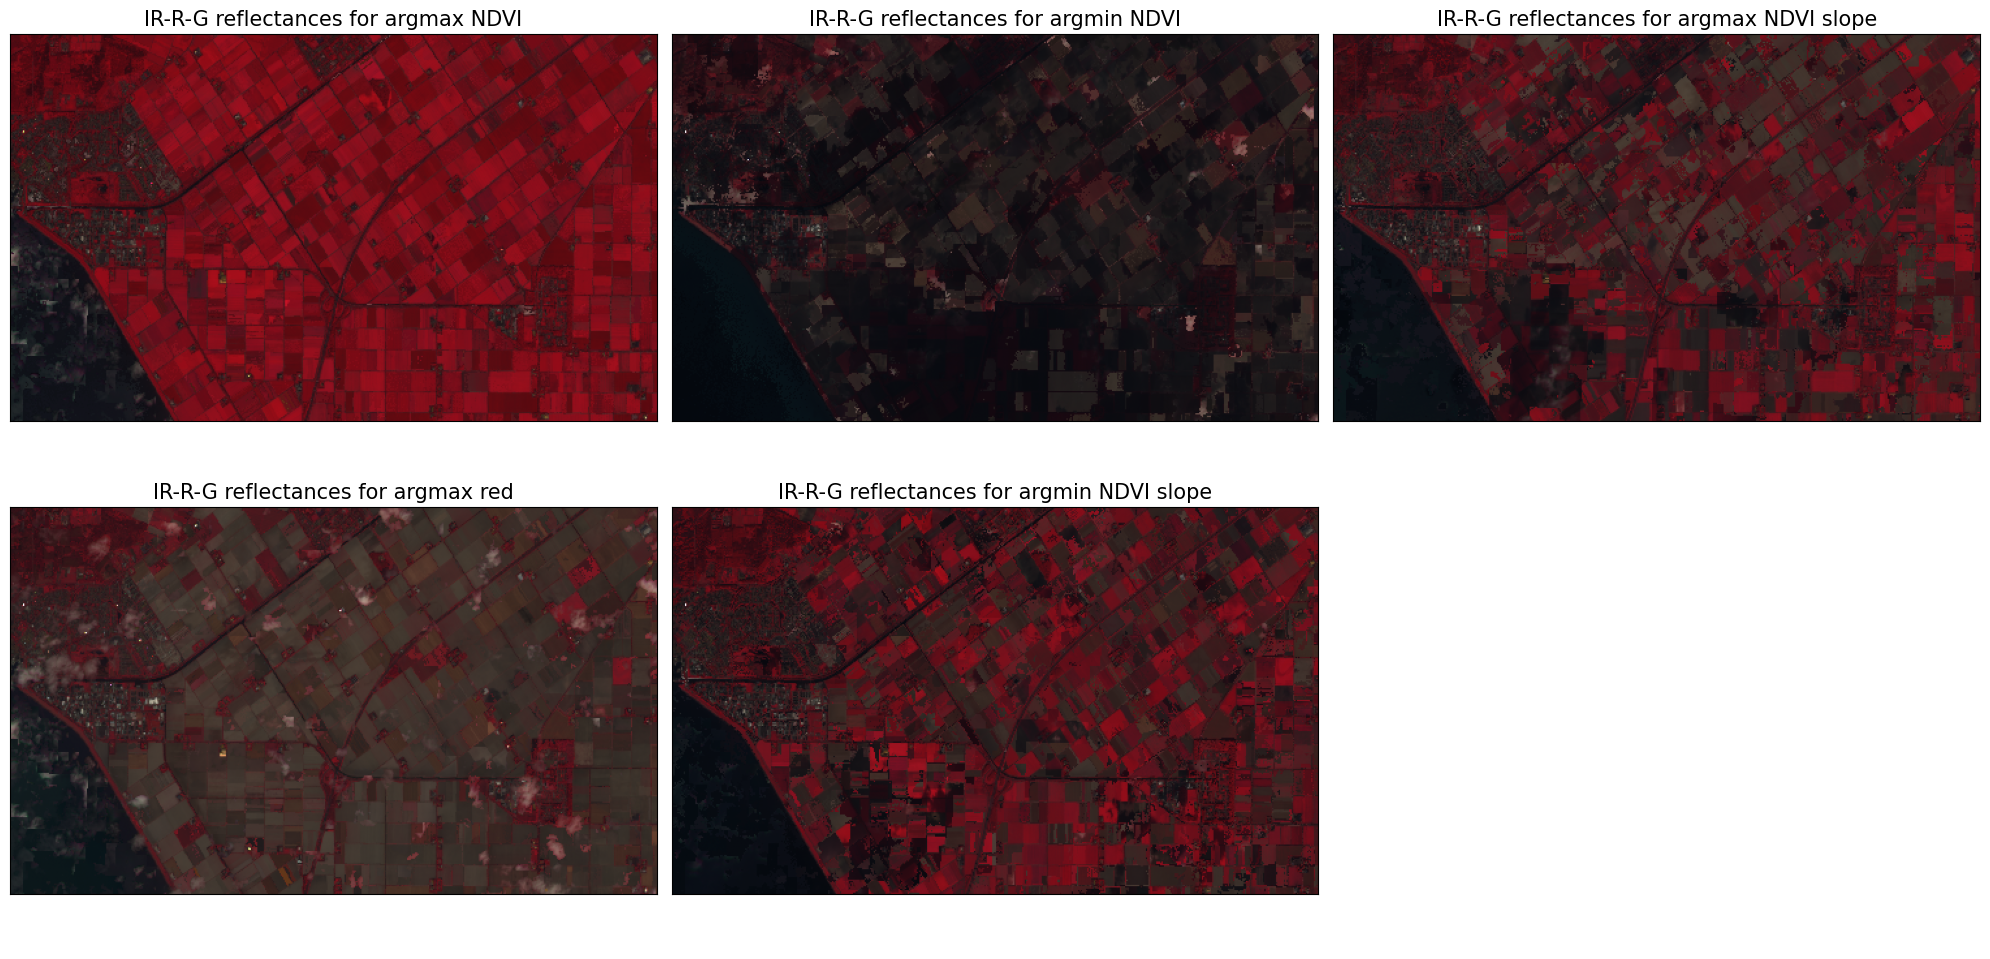

In [22]:
# False color images of NDVI features
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': True}
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(20,10), subplot_kw = subplot_kw)

ax = axs[0,0]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[2,1,0]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI", fontsize=15)

ax = axs[0,1]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[6,5,4]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI", fontsize=15)

ax = axs[0,2]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[10,9,8]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax NDVI slope", fontsize=15)

ax = axs[1,1]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[14,13,12]], 0, 1))
ax.set_title("IR-R-G reflectances for argmin NDVI slope", fontsize=15)

ax = axs[1,0]
ax.imshow(np.clip(eop_interp.data_timeless['STF'][:,:,[18,17,16]], 0, 1))
ax.set_title("IR-R-G reflectances for argmax red", fontsize=15);

ax = axs[1,2]
ax.axis(False);

plt.tight_layout()